In [2]:
from NeuralNet import NeuralNet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.datasets import fetch_openml

In [15]:
NN = NeuralNet(depth=2, learning_rate=0.1, s_in=784, s_out=10)

In [3]:
X, y = fetch_openml("mnist_784", return_X_y=True)
X = X / 255

In [ ]:
y = np.array([[1 if i == int(x) else 0 for i in range(10)] for x in y])

In [4]:
def print_data(x):
    k = "-oiOI"
    for i in range(28):
        for j in range(28):
            idx = int(np.floor(x[i * 28 + j] * 4))
            print(k[idx], end="")
        print()

In [12]:
loss = NN.train(X, y, 1, batch=100, verbose=True)

Epoch: 0 / 0 -- learning_rate: 0.1 -- loss: 24.14484420002981


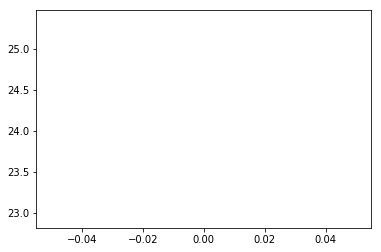

In [6]:
x = np.arange(len(loss))
plt.plot(x, loss)

In [11]:
NN.forward(X[12])

array([8.24230129e-119, 2.16020725e-134, 3.23857195e-173, 6.92917968e-121,
       1.08327816e-095, 2.37670934e-113, 1.66593423e-072, 8.84894984e-117,
       1.23225938e-024, 8.49973601e-076])

In [8]:
NN.forward(X[12])

array([8.24230129e-119, 2.16020725e-134, 3.23857195e-173, 6.92917968e-121,
       1.08327816e-095, 2.37670934e-113, 1.66593423e-072, 8.84894984e-117,
       1.23225938e-024, 8.49973601e-076])

In [13]:
y[12].sum()

1

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd', alpha=0, hidden_layer_sizes=(784, 2), random_state=1, activation='logistic')
clf.fit(X, y)